# Paris NWP runs
Some explaination and documentation about the NWP runs for the Paris case study. 

In [1]:
# Import necessary libraries

import os
import wget

import earthkit.data
import earthkit.plots
import matplotlib.pyplot as plt

from versions import UrbanAirData

g = 9.81

In [2]:
# Remote location of data for this version

# Directory of the runs
version = "0.2"
datadir = f"data/{version}"

if not os.path.isdir(datadir):
    os.makedirs(datadir)

url = UrbanAirData().url_version(version)
print(f"UrbanAir data v{version}, location:{url}")

UrbanAir data v0.2, location:http://exporter.nsc.liu.se/bd6b45b289f44b08a0ae82055591ce99


In [3]:
# Leadtime
step = 1
date = "20230820"

In [9]:
date_path = f"{date[:4]}/{date[4:6]}/{date[6:]}"
demo_files = {
    "atmo_file": f"{date_path}/GRIBPFDEOD+00{step:02d}h00m00s",
    "tile_file": f"{date_path}/GRIBTILEDEOD+00{step:02d}h00m00s.sfx",
    "const_file": "Const.Clim.grib2",
    #"readme": "README.md",
}

for filename in demo_files.values():
    target = f"{datadir}/{filename}"
    if not os.path.isfile(target):
        file_url = f"{url}/{filename}"
        file_path = os.path.dirname(target)
        print(f"Downloading: {file_url} to {file_path}")
        os.makedirs(file_path, exist_ok=True)
        wget.download(file_url, file_path)
    else:
        print(f"File already exists: {target}")

Downloading: http://exporter.nsc.liu.se/bd6b45b289f44b08a0ae82055591ce99/2023/08/20/GRIBPFDEOD+0001h00m00s to data/0.2/2023/08/20
100% [......................................................................] 955922151 / 955922151Downloading: http://exporter.nsc.liu.se/bd6b45b289f44b08a0ae82055591ce99/2023/08/20/GRIBTILEDEOD+0001h00m00s.sfx to data/0.2/2023/08/20
100% [......................................................................] 111247898 / 111247898Downloading: http://exporter.nsc.liu.se/bd6b45b289f44b08a0ae82055591ce99/Const.Clim.grib2 to data/0.2
100% [..........................................................................] 6030963 / 6030963

In [10]:
def read(filename):
  file_name = os.path.join(datadir, filename)
  data = earthkit.data.from_source("file", file_name)
  return data
    
def plotme(x,title):
 chart = earthkit.plots.Map()
 chart.quickplot(x)
 chart.coastlines()
 chart.land()
 chart.borders()
 chart.gridlines()
 try:
    chart.legend()
 except:
    pass
 chart.title(title)
 chart.show()

## Constant files 
The `Const.Clim.grib2` files contain the land-sea mask an the height of the orography. They can be read and plotted as follows.

In [11]:
data = read(demo_files["const_file"])
data.ls(extra_keys=["tile"])

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType,tile
0,lfpw,h,surface,0,20230820,0,0,fc,None,lambert_lam,None
1,lfpw,tifr,surface,0,20230820,0,0,fc,None,lambert_lam,GNATU
2,lfpw,tifr,surface,0,20230820,0,0,fc,None,lambert_lam,GIWAT
3,lfpw,tifr,surface,0,20230820,0,0,fc,None,lambert_lam,SEAO
4,lfpw,tifr,surface,0,20230820,0,0,fc,None,lambert_lam,GLCZU
5,lfpw,lsm,surface,0,20230820,0,0,fc,None,lambert_lam,None


In [12]:
geometry_attributes = [
    "gridType",
    "Nx",
    "Ny",
    "DxInMetres",
    "DyInMetres",
    "latitudeOfFirstGridPointInDegrees",
    "longitudeOfFirstGridPointInDegrees",
    "Latin1InDegrees",
    "Latin2InDegrees",
    "LaDInDegrees",
    "LoVInDegrees"
]
geometry = {k:data[0].metadata(k) for k in geometry_attributes}
for k,v in geometry.items():
    print(f"  {k}: {v}")

  gridType: lambert_lam
  Nx: 989
  Ny: 989
  DxInMetres: 500.0
  DyInMetres: 500.0
  latitudeOfFirstGridPointInDegrees: 46.582186
  longitudeOfFirstGridPointInDegrees: 359.119746
  Latin1InDegrees: 48.85
  Latin2InDegrees: 48.85
  LaDInDegrees: 48.85
  LoVInDegrees: 2.35


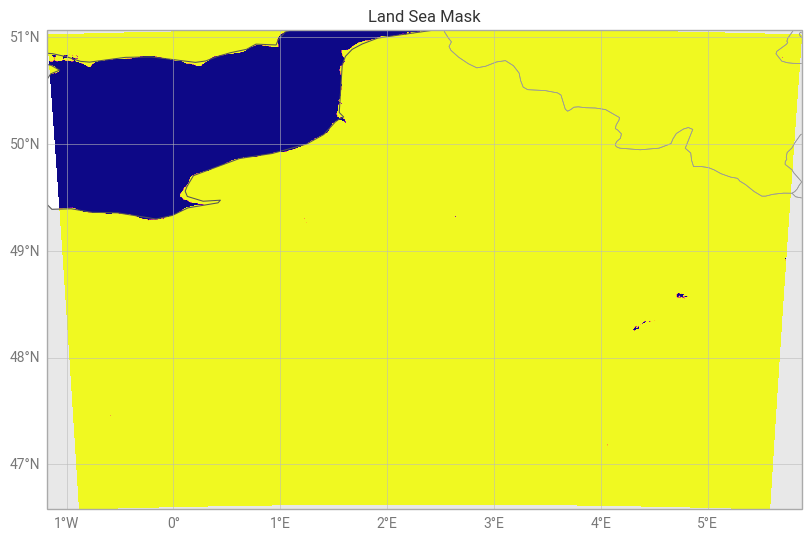

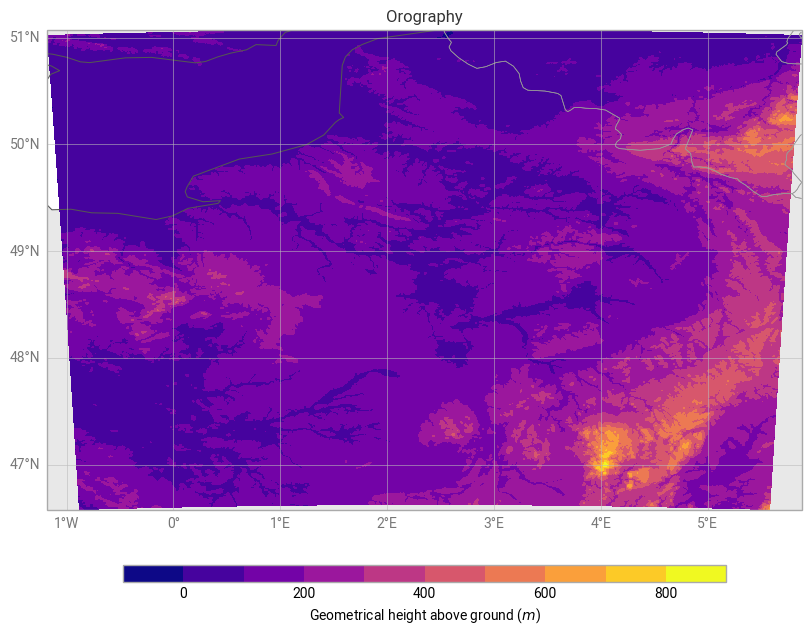

In [13]:
plotme(data.sel({"shortName": "lsm"}),"Land Sea Mask")
plotme(data.sel({"shortName": "h"}),"Orography")

We can also plot the various land use fractions

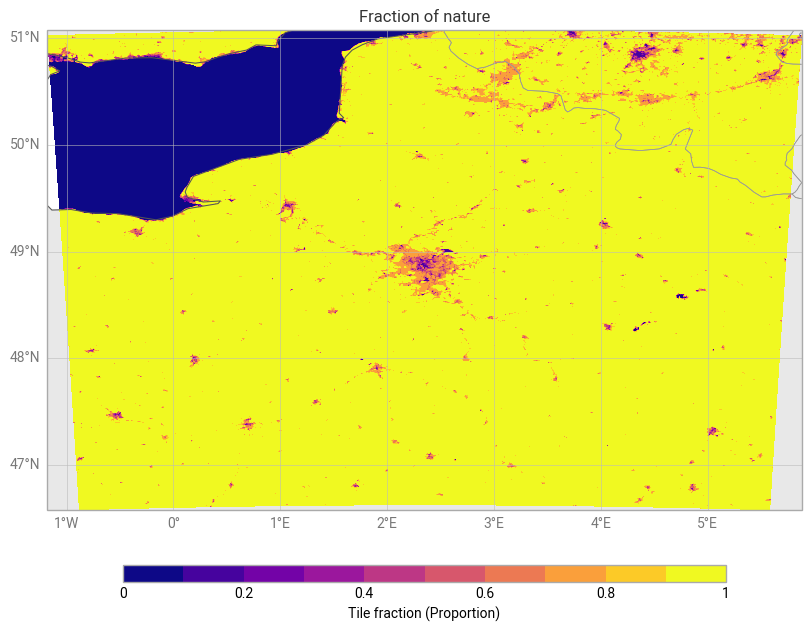

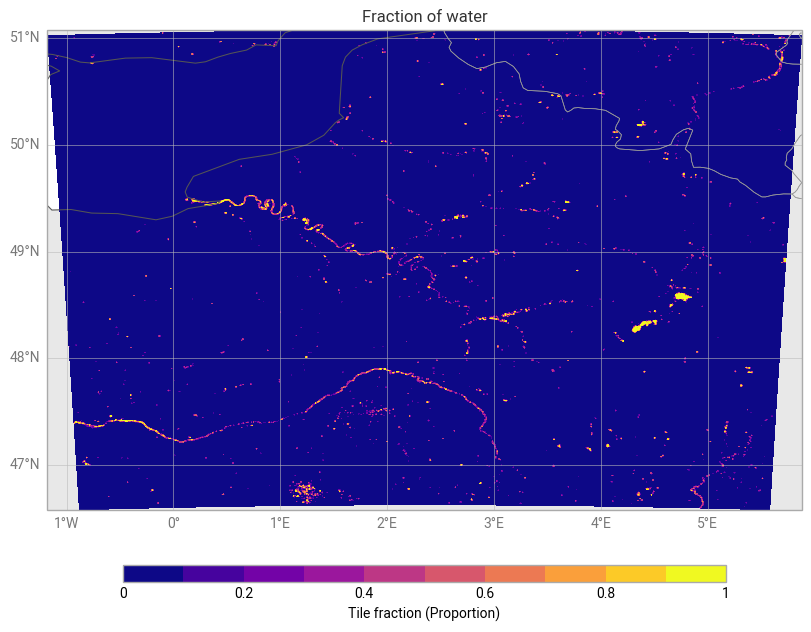

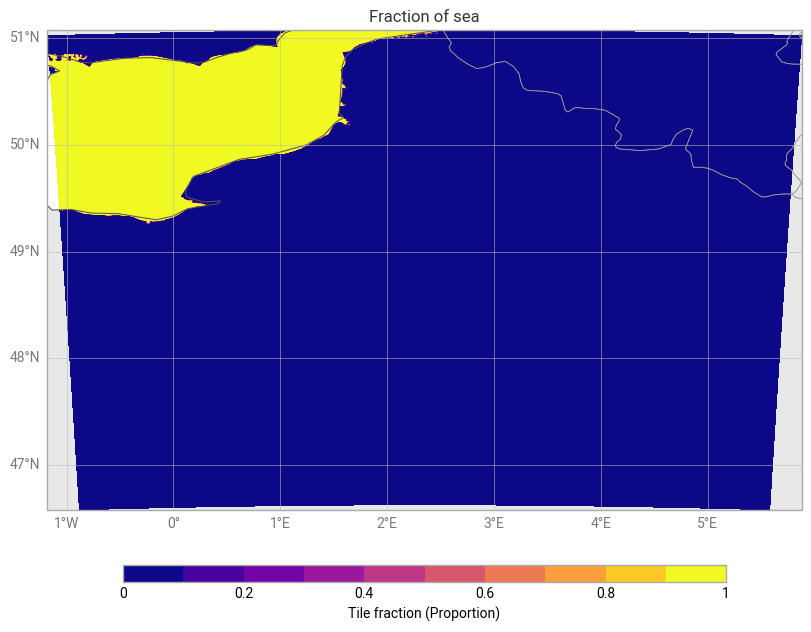

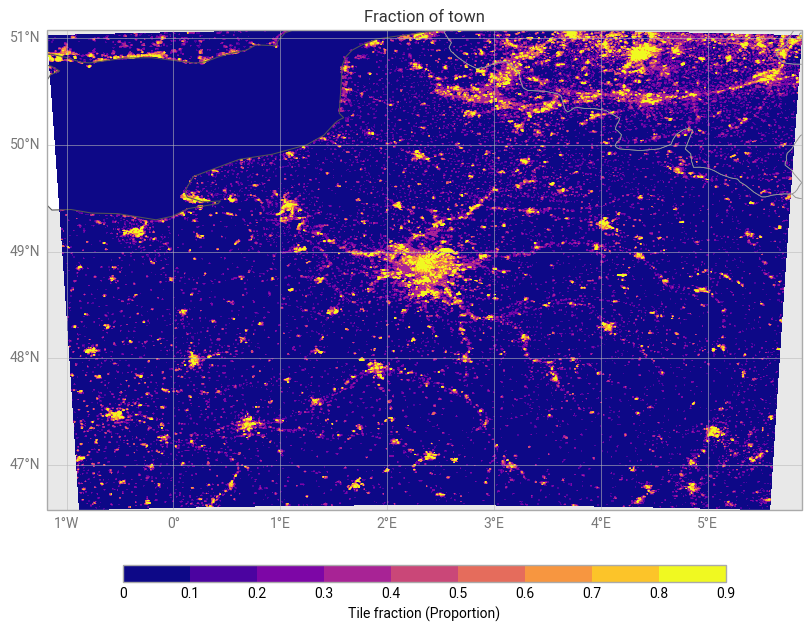

In [14]:
plotme(data.sel({"shortName": "tifr", "tile": "GNATU"}),"Fraction of nature")
plotme(data.sel({"shortName": "tifr", "tile": "GIWAT"}),"Fraction of water")
plotme(data.sel({"shortName": "tifr", "tile": "SEAO"}),"Fraction of sea")
plotme(data.sel({"shortName": "tifr", "tile": "GLCZU"}),"Fraction of town")

# Soil and soil moisture
AROME/HARMONIE-AROME uses surface model SURFEX. For these runs a diffusion scheme is used for the soil.

The soil scheme consists of 14 layers, 0.01, 0.04, 0.10, 0.20, 0.40, 0.60, 0.80, 1.0, 1.5, 2.0, 3.0, 4.0, 8.0, 12.0 meter.
In these simulations, we only use three tiles (bare soil, low vegetation, and high vegetation). 

![](https://www.umr-cnrm.fr/IMG/png/fig1-2.png)

The soil data provided is either on the whole nature tile, or on each of the patches.
The soil files are called `GRIBTILEDEODE+HHHHhMMmSSs.sfx`, and can be read as indicated below. 

In the `filter_by_keys` function you can select which tile you want the soil data to selected, where `GNATU` is the aggregated over all the three nature tiles, `GNOVE` is the bare soil tile, `GTREE` is the high vegetation tile, `GLVEG` is the low vegetation tile. 

In [15]:
data = read(demo_files["tile_file"])
data.ls(extra_keys=["tile"])

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType,tile
0,lfpw,liqvsm,soilLayer,1,20230820,0,1,fc,None,lambert_lam,GNATU
1,lfpw,sot,soilLayer,1,20230820,0,1,fc,None,lambert_lam,GNATU
2,lfpw,liqvsm,soilLayer,2,20230820,0,1,fc,None,lambert_lam,GNATU
3,lfpw,sot,soilLayer,2,20230820,0,1,fc,None,lambert_lam,GNATU
4,lfpw,liqvsm,soilLayer,3,20230820,0,1,fc,None,lambert_lam,GNATU
...,...,...,...,...,...,...,...,...,...,...,...
110,lfpw,sot,soilLayer,14,20230820,0,1,fc,None,lambert_lam,GLVEG
111,lfpw,sot,soilLayer,14,20230820,0,1,fc,None,lambert_lam,GTREE
112,lfpw,tifr,surface,0,20230820,0,1,fc,None,lambert_lam,GNOVE
113,lfpw,tifr,surface,0,20230820,0,1,fc,None,lambert_lam,GLVEG


In [16]:
soil = data.sel({"tile": "GNATU"}).to_xarray()
soil

<xarray.Dataset> Size: 235MB
Dimensions:    (levelist: 14, y: 989, x: 989)
Coordinates:
  * levelist   (levelist) int64 112B 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    latitude   (y, x) float64 8MB ...
    longitude  (y, x) float64 8MB ...
Dimensions without coordinates: y, x
Data variables:
    liqvsm     (levelist, y, x) float64 110MB ...
    sot        (levelist, y, x) float64 110MB ...
Attributes:
    levtype:      sol
    date:         20230820
    time:         0
    Conventions:  CF-1.8
    institution:  ECMWF

Here the soil moisture is `liqvsm` and soil temperature is `sot` and are a function of each of the 14 soil layers and `x` and `y`.

Here is an example of the soil temperature and moisture at different points in the domain. 

Text(0, 0.5, 'Soil depth (m)')

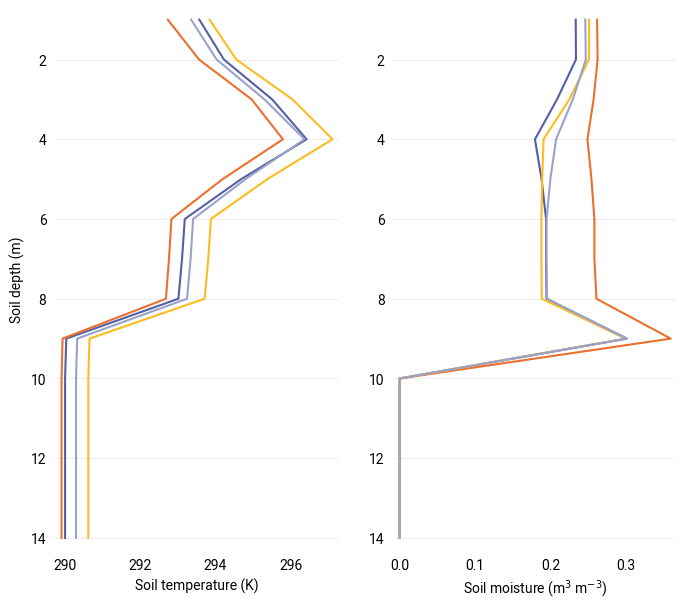

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(soil.sot[::-1, 70, 70], soil.levelist[::-1])
ax1.plot(soil.sot[::-1, 30, 30], soil.levelist[::-1])
ax1.plot(soil.sot[::-1, 100, 100], soil.levelist[::-1])
ax1.plot(soil.sot[::-1, 100, 70], soil.levelist[::-1])
ax1.invert_yaxis()
ax2.invert_yaxis()
ax2.plot(soil.liqvsm[::-1, 70, 70], soil.levelist[::-1])
ax2.plot(soil.liqvsm[::-1, 30, 30], soil.levelist[::-1])
ax2.plot(soil.liqvsm[::-1, 100, 100], soil.levelist[::-1])
ax2.plot(soil.liqvsm[::-1, 100, 70], soil.levelist[::-1])
ax1.set_xlabel("Soil temperature (K)")
ax2.set_xlabel(r"Soil moisture (m$^{3}$ m$^{-3}$)")
ax1.set_ylabel("Soil depth (m)")

## Atmospheric fields
For the atmospheric files (`GRIBPFDEOD+HHHHhMMmSSs`) several fields are provided. Check the listing below for fields stored.
In order to read in the fields stored on model levels (hybrid), you can select the `typeOfLevel` to be `hybrid`. 

In [18]:
data = read(demo_files["atmo_file"])
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,lfpw,sd,surface,0.0,20230820,0,1,fc,None,lambert_lam
1,lfpw,t,surface,0.0,20230820,0,1,fc,None,lambert_lam
2,lfpw,tsr,nominalTop,0.0,20230820,0,0-1,fc,None,lambert_lam
3,lfpw,ttr,nominalTop,0.0,20230820,0,0-1,fc,None,lambert_lam
4,lfpw,tgrp,surface,0.0,20230820,0,0-1,fc,None,lambert_lam
...,...,...,...,...,...,...,...,...,...,...
1695,lfpw,wz,hybrid,86.0,20230820,0,1,fc,None,lambert_lam
1696,lfpw,wz,hybrid,87.0,20230820,0,1,fc,None,lambert_lam
1697,lfpw,wz,hybrid,88.0,20230820,0,1,fc,None,lambert_lam
1698,lfpw,wz,hybrid,89.0,20230820,0,1,fc,None,lambert_lam


In [19]:
atm = data.sel({"typeOfLevel": "hybrid"}).to_xarray()
atm

<xarray.Dataset> Size: 9GB
Dimensions:    (levelist: 90, y: 989, x: 989)
Coordinates:
  * levelist   (levelist) int64 720B 1 2 3 4 5 6 7 8 ... 83 84 85 86 87 88 89 90
    latitude   (y, x) float64 8MB ...
    longitude  (y, x) float64 8MB ...
Dimensions without coordinates: y, x
Data variables: (12/13)
    cc         (levelist, y, x) float64 704MB ...
    ciwc       (levelist, y, x) float64 704MB ...
    clwc       (levelist, y, x) float64 704MB ...
    crwc       (levelist, y, x) float64 704MB ...
    cswc       (levelist, y, x) float64 704MB ...
    grle       (levelist, y, x) float64 704MB ...
    ...         ...
    t          (levelist, y, x) float64 704MB ...
    tke        (levelist, y, x) float64 704MB ...
    u          (levelist, y, x) float64 704MB ...
    v          (levelist, y, x) float64 704MB ...
    wz         (levelist, y, x) float64 704MB ...
    z          (levelist, y, x) float64 704MB ...
Attributes:
    levtype:      ml
    date:         20230820
    time:         0
    Conventions:  CF-1.8
    institution:  ECMWF

Text(0, 0.5, 'Altitude (m)')

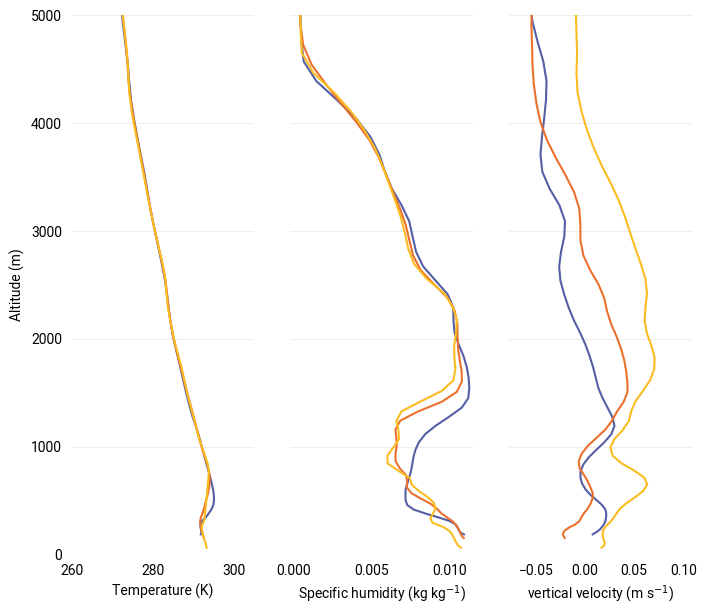

In [20]:
t = atm.t.data
q = atm.q.data
z = atm.z.data /g
w = atm.wz.data

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
for x in [30,70,100]:
  ax1.plot(t[::-1, x, x], z[::-1, x, x])
  ax2.plot(q[::-1, x, x], z[::-1, x, x])
  ax3.plot(w[::-1, x, x], z[::-1, x, x])
ax1.set_ylim(0, 5000)
ax1.set_xlim(260, 305)
ax1.set_xlabel("Temperature (K)")
ax2.set_xlabel(r"Specific humidity (kg kg$^{-1}$)")
ax3.set_xlabel(r"vertical velocity (m s$^{-1}$)")
ax1.set_ylabel("Altitude (m)")